# Lab 5 - Grad Lab

## Question: How does a KNN model predict if a college is public school?

### Cleaning Data

#### Import Data

In [53]:
import pandas as pd

grad_data = pd.read_csv('https://query.data.world/s/qpi2ltkz23yp2fcaz4jmlrskjx5qnp', encoding="cp1252")
grad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   unitid                                3798 non-null   int64  
 1   chronname                             3798 non-null   object 
 2   city                                  3798 non-null   object 
 3   state                                 3798 non-null   object 
 4   level                                 3798 non-null   object 
 5   control                               3798 non-null   object 
 6   basic                                 3798 non-null   object 
 7   hbcu                                  94 non-null     object 
 8   flagship                              50 non-null     object 
 9   long_x                                3798 non-null   float64
 10  lat_y                                 3798 non-null   float64
 11  site             

#### Dropping Variables 

In [54]:
# variables that don't look predictive 
to_drop = list(range(39, 56))
to_drop.extend([27, 9, 10, 11, 28, 36, 60, 56])
grad_data1 = grad_data.drop(grad_data.columns[to_drop], axis=1)
drop_more = [0,2,3,6,8,11,12,14,15,18,21,23,29,32,33,34,35]
grad_data2 = grad_data1.drop(grad_data1.columns[drop_more], axis=1)
print(grad_data2.head())

                             chronname   level                 control hbcu  \
0               Alabama A&M University  4-year                  Public    X   
1  University of Alabama at Birmingham  4-year                  Public  NaN   
2                   Amridge University  4-year  Private not-for-profit  NaN   
3  University of Alabama at Huntsville  4-year                  Public  NaN   
4             Alabama State University  4-year                  Public    X   

   student_count  awards_per_value  exp_award_value  exp_award_percentile  \
0           4051              14.2           105331                    90   
1          11502              20.9           136546                    97   
2            322              29.9            58414                    30   
3           5696              20.9            64418                    61   
4           5356              11.6           132407                    96   

   ft_pct  fte_percentile  med_sat_value  aid_value  grad_100_

#### Variables to Factors 

In [55]:
import numpy as np
grad_data2.replace('NULL', np.nan, inplace=True)
grad_data2['hbcu'] = [1 if grad_data2['hbcu'][i]=='X' else 0 for i in range(len(grad_data2['hbcu']))]
grad_data2['hbcu'].value_counts()
grad_data2['hbcu'] = grad_data2.hbcu.astype('category')
grad_data2[['level', 'control']] = grad_data2[['level', 'control']].astype('category')
grad_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   chronname             3798 non-null   object  
 1   level                 3798 non-null   category
 2   control               3798 non-null   category
 3   hbcu                  3798 non-null   category
 4   student_count         3798 non-null   int64   
 5   awards_per_value      3798 non-null   float64 
 6   exp_award_value       3798 non-null   int64   
 7   exp_award_percentile  3798 non-null   int64   
 8   ft_pct                3794 non-null   float64 
 9   fte_percentile        3798 non-null   int64   
 10  med_sat_value         1337 non-null   float64 
 11  aid_value             3797 non-null   float64 
 12  grad_100_value        3467 non-null   float64 
 13  grad_100_percentile   3467 non-null   float64 
 14  grad_150_value        3467 non-null   float64 
 15  grad

#### Graphing Missing Values 

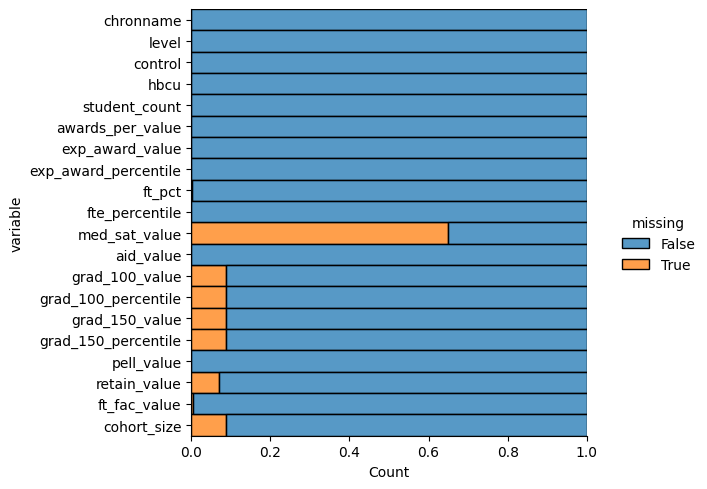

In [56]:
import seaborn as sns

sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

#### Dropping Med_Sat_Value and Missing Values

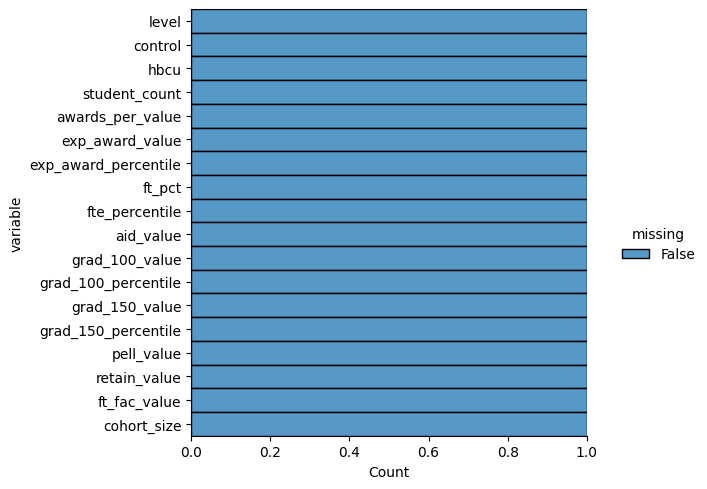

In [57]:
grad_data2 = grad_data2.drop(grad_data[['med_sat_value']], axis=1)
grad_data2 = grad_data2.drop(grad_data[['chronname']], axis=1) # drop object 
grad_data2.dropna(axis = 0, how = 'any', inplace = True)
sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

### Building KNN Model

#### Normalize Numeric Values 

In [58]:
from sklearn import preprocessing

numeric_cols = grad_data2.select_dtypes(include=['int64', 'float64']).columns

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(grad_data2[numeric_cols])   # conduct data transformation
scaled_df = pd.DataFrame(d, columns=numeric_cols)  
grad_data2[numeric_cols] = scaled_df  
grad_data2.describe()

,student_count,awards_per_value,exp_award_value,exp_award_percentile,ft_pct,fte_percentile,aid_value,grad_100_value,grad_100_percentile,grad_150_value,grad_150_percentile,pell_value,retain_value,ft_fac_value,cohort_size
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000
mean,0.028538,0.168413,0.012989,0.521395,0.703992,0.516588,0.197336,0.286835,0.474713,0.428755,0.494324,0.452812,0.667870,0.472318,0.042465
std,0.044812,0.074907,0.022193,0.286257,0.259193,0.288517,0.162857,0.231574,0.302494,0.231190,0.292061,0.192148,0.158788,0.241401,0.060441
min,0.000000,0.000000,0.000000,0.000000,0.006237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004594,0.126340,0.006494,0.280000,0.476611,0.270000,0.092223,0.094000,0.210000,0.237000,0.240000,0.315000,0.564500,0.281000,0.009613
50%,0.012327,0.156968,0.010044,0.530000,0.776507,0.530000,0.127307,0.231000,0.470000,0.415000,0.490000,0.427000,0.672000,0.444000,0.023170
75%,0.033902,0.189127,0.015248,0.770000,0.937630,0.770000,0.254348,0.438000,0.740000,0.604000,0.750000,0.575000,0.781000,0.646000,0.050622
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Onehot Encode 

In [59]:
cat_cols = grad_data2.select_dtypes(include='category').columns

encoded = pd.get_dummies(grad_data2[cat_cols])
encoded.head()  

,level_2-year,level_4-year,control_Private for-profit,control_Private not-for-profit,control_Public,hbcu_0,hbcu_1
0,False,True,False,False,True,False,True
1,False,True,False,False,True,True,False
2,False,True,False,True,False,True,False
3,False,True,False,False,True,True,False
4,False,True,False,False,True,False,True


#### Drop Categorical and Join Encoded Variables 

In [60]:
grad_data2 = grad_data2.drop(cat_cols, axis=1)
grad_data2 = grad_data2.join(encoded)

In [61]:
grad_data2.dropna(axis = 0, how = 'any', inplace = True)
print(grad_data2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3083 entries, 0 to 3369
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   student_count                   3083 non-null   float64
 1   awards_per_value                3083 non-null   float64
 2   exp_award_value                 3083 non-null   float64
 3   exp_award_percentile            3083 non-null   float64
 4   ft_pct                          3083 non-null   float64
 5   fte_percentile                  3083 non-null   float64
 6   aid_value                       3083 non-null   float64
 7   grad_100_value                  3083 non-null   float64
 8   grad_100_percentile             3083 non-null   float64
 9   grad_150_value                  3083 non-null   float64
 10  grad_150_percentile             3083 non-null   float64
 11  pell_value                      3083 non-null   float64
 12  retain_value                    3083 no

#### Prevalence of Public College

In [62]:
print(grad_data2['control_Public'].value_counts()[1] / grad_data2['control_Public'].count())
# we have 44% chance of predicting the right control

0.4758352254297762


/tmp/ipykernel_957/1158147367.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(grad_data2['control_Public'].value_counts()[1] / grad_data2['control_Public'].count())


#### Train/Test Split

In [63]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(grad_data2, test_size=0.2, stratify=grad_data2['control_Public'], random_state=99)
test, val = train_test_split(test, test_size=0.2, stratify=test['control_Public'], random_state=99)

#### Training Classifier 

In [66]:
import random
from sklearn.neighbors import KNeighborsClassifier
random.seed(99)  

X_train = train.drop(['control_Public'], axis=1).values
y_train = train['control_Public'].values

neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

#### Evaluate Test Data Accuracy 

In [67]:
X_val = val.drop(['control_Public'], axis=1).values
y_val = val['control_Public'].values

print(neigh.score(X_val, y_val))

1.0


#### Evaluate Validation Data Accuracy

In [68]:
X_test = test.drop(['control_Public'], axis=1).values
y_test = test['control_Public'].values

print(neigh.score(X_test, y_test))

1.0
